# Part 3: ECG Analysis

## Introduction

In this part, you'll work with the MIT-BIH Arrhythmia Database to build a model for heartbeat classification using a simple neural network architecture. This will help you understand how to apply neural networks to time series data in healthcare.

## Learning Objectives

- Load and preprocess ECG time series data
- Implement a simple neural network for sequence classification
- Train and evaluate the model
- Interpret results in a clinical context

## Setup and Installation

In [2]:
# Install required packages
# %pip install -r requirements.txt
%pip install wfdb  # For reading MIT-BIH format

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
from scipy import signal
import urllib.request
import zipfile

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_3', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Download MIT-BIH dataset
data_dir = 'data/mitdb'
if not os.path.exists(data_dir):
    print("Downloading MIT-BIH Arrhythmia Database...")
    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    zip_path = 'data/mitdb.zip'
    
    # Download dataset
    urllib.request.urlretrieve(url, zip_path)
    
    # Extract dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    # Clean up
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully.")    


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Dataset downloaded and extracted successfully.


## 1. Data Loading and Preprocessing

Signal shape: (650000, 2)
Number of annotations: 2274
Unique beat types: ['+' 'A' 'N' 'V']


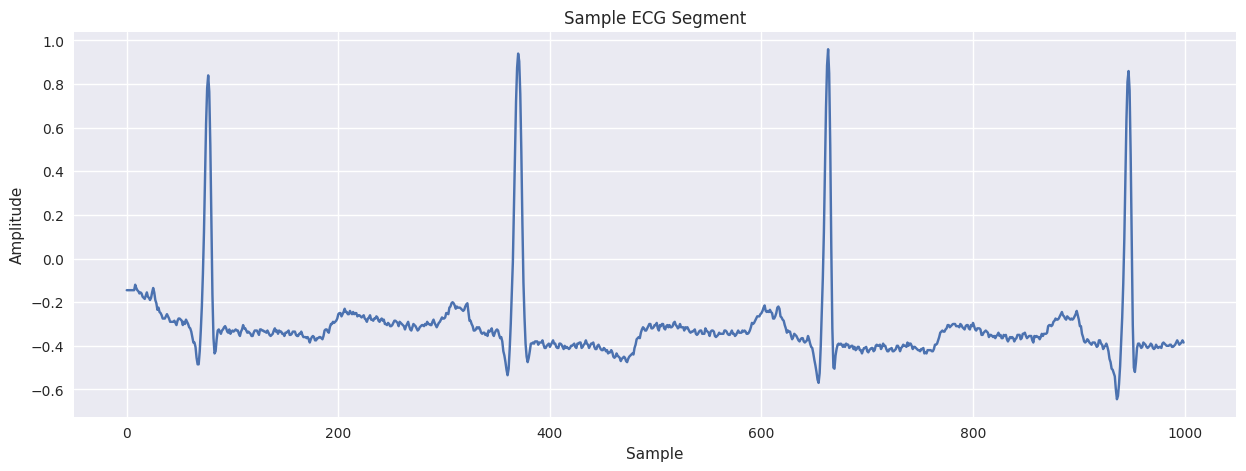

In [4]:
# Load ECG data
record_path = 'data/mit-bih-arrhythmia-database-1.0.0//100'  # Example record
record = wfdb.rdrecord(record_path)
signals = record.p_signal

# Read annotations
ann = wfdb.rdann(record_path, 'atr')
annotations = ann.symbol

# Print data information
print(f"Signal shape: {signals.shape}")
print(f"Number of annotations: {len(annotations)}")
print(f"Unique beat types: {np.unique(annotations)}")

# Plot sample ECG segment
plt.figure(figsize=(15, 5))
plt.plot(signals[:1000, 0])
plt.title('Sample ECG Segment')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Data shape: (2273, 180, 2)
Label distribution: [2239   34]


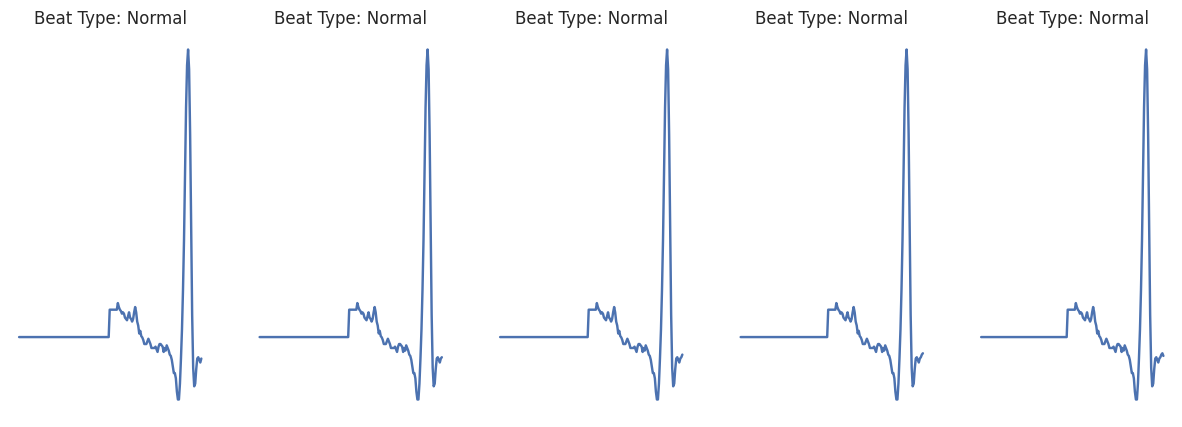

In [5]:
# Preprocess ECG data
window_size = 180

# Normalize signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Extract beats
X = []
y = []

for i, ann in enumerate(annotations):
    if ann in ['N', 'L', 'R', 'A', 'V']:  # Normal and abnormal beats
        # Get window around beat
        start = max(0, i - window_size//2)
        end = min(len(signals), i + window_size//2)
        
        # Pad if necessary
        if start == 0:
            pad_left = window_size//2 - i
            segment = np.pad(signals[start:end], ((pad_left, 0), (0, 0)))
        elif end == len(signals):
            pad_right = window_size//2 - (len(signals) - i)
            segment = np.pad(signals[start:end], ((0, pad_right), (0, 0)))
        else:
            segment = signals[start:end]
        
        X.append(segment)
        
        # Convert annotation to label
        if ann == 'N':
            y.append(0)  # Normal
        else:
            y.append(1)  # Abnormal

X = np.array(X)
y = np.array(y)

print(f"Data shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Plot sample beats
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X[i, :, 0])
    plt.title(f'Beat Type: {"Normal" if y[i] == 0 else "Abnormal"}')
    plt.axis('off')
plt.show()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 2. Model Implementation

In [7]:
from tensorflow.keras import layers, models

# Create simple neural network
def create_simple_nn(input_shape):
    """
    Create a simple neural network for ECG classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use binary crossentropy loss
    - Must include AUC metric
    
    Goals:
    - Achieve > 75% accuracy on test set
    - Achieve AUC > 0.80
    - Achieve F1-score > 0.70
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (180, 2) for ECG windows)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),  # Flatten (180, 2) → 360
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(180, 2))
model.summary()

2025-05-14 08:27:16.729020: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        46,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,529 (213.00 KB)

 Trainable params: 54,529 (213.00 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Training and Evaluation

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8468 - auc: 0.4687 - loss: 0.3393 - val_accuracy: 0.9945 - val_auc: 0.4130 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - auc: 0.7057 - loss: 0.0715 - val_accuracy: 0.9945 - val_auc: 0.3315 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - auc: 0.6825 - loss: 0.0794 - val_accuracy: 0.9945 - val_auc: 0.3218 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - auc: 0.7297 - loss: 0.0775 - val_accuracy: 0.9945 - val_auc: 0.3453 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - auc: 0.6704 - loss: 0.0824 - val_accuracy: 0.9945 - val_auc: 0.3494 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - auc: 0.7709 - loss

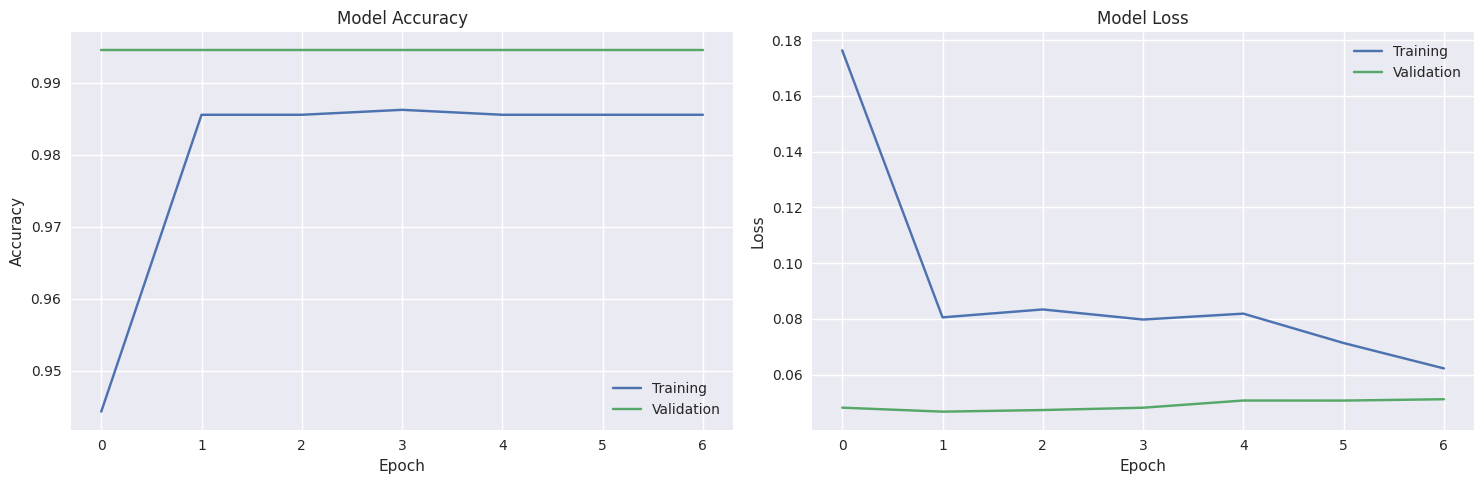

In [8]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/ecg_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - auc: 0.4191 - loss: 0.1881 
Test accuracy: 0.9758
Test AUC: 0.5207
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


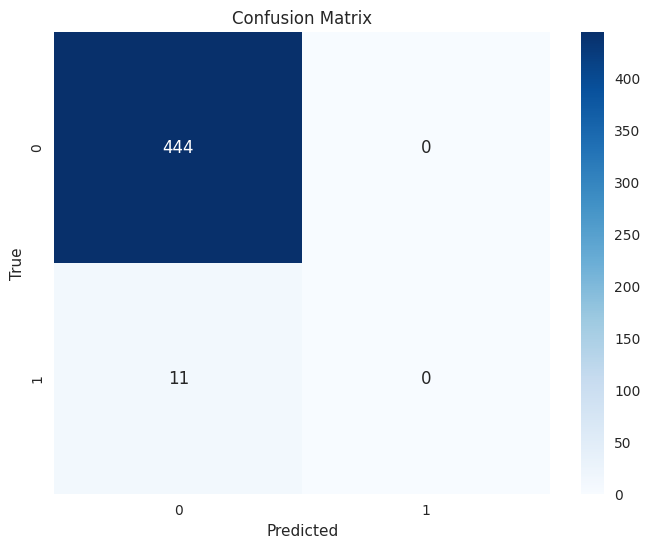

/tmp/ipykernel_29976/3918600470.py:23: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [9]:
# Evaluate model
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.numpy().ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# Save metrics
metrics = {
    'model': 'ecg_classifier',
    'accuracy': float(test_accuracy),
    'auc': float(test_auc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_3/ecg_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"auc: {metrics['auc']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully download MIT-BIH dataset
   - [ ] Load and visualize ECG signals
   - [ ] Verify signal shape and annotations

2. **Preprocessing**:
   - [ ] Normalize signals
   - [ ] Extract beat windows
   - [ ] Verify window shapes and labels

3. **Model Implementation**:
   - [ ] Create simple neural network
   - [ ] Verify model architecture
   - [ ] Test model output shape

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: MIT-BIH dataset not found
   - Solution: Check internet connection and wfdb installation

2. **Preprocessing Issues**:
   - Problem: Signal normalization errors
   - Solution: Check signal statistics and normalization method
   - Problem: Window extraction errors
   - Solution: Verify window size and padding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters